## Topic Modeling with NMF and SVD

#### The Problem 
        Topic modeling is a fun way to start the study of NLP. We will use two popular matrix decomposition techniques.

        We start with a term-document matrix:

        We can decompose this into one tall think matrix times one wide short matrix (possibly with a diagnol matrix in between).

        Notice that this representation does not take into account word order or sentence structure. It's an example of a bag of words approach.


    Latent Semantic Analysis (LSA) uses Singular Value Decomposition (SVD) 


### Motivation
     Consider the most extreme case - reconstructing the matrix using an outer product of two vectors. In most of the cases we won't be able to reconstruct the matrix exactly. But if we had one vector with the relative frequency of each vocabulary word out of the total word count,and one with the average number of words per document, then that outer product be as close as we can get.


     Now consider increasing that matrices to two columns and two rows. The optimal decomposition would now be to cluster the document into two groups, each of which has as different distribution of words as possible to each other, but as similar as possible amongst the document in the cluster. We will call those two groups "topics". And we ould cluster the words into two groups, based on those which most frequently appear in each of the topics.

### Getting Started
         We'll take a dataset of documents in several different categories, and find topics(consisting of groups of words) from them. Knowing the actual categories help us evaluate if the topics we find make sense.


         We will try this with two different matrix factorizations: Singular Value Decomposition and Non-negative Matrix Factorization (NMF) 

In [1]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
np.set_printoptions(suppress= True)

#### Addition Resource:
[Data Source](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html) : News groups are discussing groups on Usenet, which was popular in the 80s and 90s before the web really took off. This dataset contains 18,000 newsgroups posts with 20 topics

### Look at our data
        Scikit Leanr comes with a number of built in datasets, as well as loading utilities to load several standard external datasets. This is a great resource and the datasets include Boston housing prices, face images, patches of forests, diabetes, breast cancer and more

In [3]:
categories = ['alt.atheism','talk.religion.misc','comp.graphics', 'sci.space']
remove = ('headers', 'footers','quotes')

newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)


In [4]:
newsgroups_train.filenames.shape, newsgroups_train.target.shape

((2034,), (2034,))

Let us look at some of the data, guess ewhichc  category these messages are in ?

In [5]:
print("\n".join(newsgroups_train.data[:4]))

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.

 >In article <1993Apr19.020359.26996@sq.sq.com>, msb@sq.sq.c

In [6]:
np.array(newsgroups_train.target_names)[newsgroups_train.target[:4]]

array(['comp.graphics', 'talk.religion.misc', 'sci.space', 'alt.atheism'],
      dtype='<U18')

The target attribute is the integer index of the category

In [7]:
# since there are four categories, the index would be 0,1,2,3
newsgroups_train.target[:4]

array([1, 3, 2, 0], dtype=int64)

In [8]:
num_topics, num_top_words = 6,8

### Stop words, Stemming, Lemmatization

        Stop Words
        Some extremely common words which would appear to be of little value in helping select documents matching a user need are excluded from the voacbulary entirely. These words are called stop words.

        The general trend in the IR systems obver time has been from standard use of quite large stop lists (200-300 terms) to very small stop list (7-12 terms)  to no stop list what so ever.
        We search engines generally do not use stop lists.



### NLTK

In [9]:
from sklearn.feature_extraction import _stop_words

sorted(list(_stop_words.ENGLISH_STOP_WORDS))[:30]

['a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amoungst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere']

#### Stemming and Lemmatization
        Are the below words same?
        1. organize
        2. organizes
        3. organizing
        and
        1. democracy
        2. demcratic
        3. democratization
        

        Stemming and Lemmatization both generate the root from the words.
        Lemmatization uses the ruls about a language. The resulting tokens are all actual words.

        "Stemming is the poor-man's lemmatization." (Noah Smith 2011). Stemming is a crude heuristic that chops the ends off of words. The resulting tokens may not be actual words. Stemming  is faster

        


In [10]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\Monit
[nltk_data]     Sharma\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [11]:
from nltk import stem

In [12]:
wnl = stem.WordNetLemmatizer()
porter = stem.porter.PorterStemmer()

In [13]:
word_list = ['feet', 'foot', 'foots', 'footing', 'footwear', 'footer']

In [14]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to C:\Users\Monit
[nltk_data]     Sharma\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [15]:

[wnl.lemmatize(word) for word in word_list]



['foot', 'foot', 'foot', 'footing', 'footwear', 'footer']

In [16]:

[porter.stem(word) for word in word_list]

['feet', 'foot', 'foot', 'foot', 'footwear', 'footer']

Stemming and Lemmatization are language dependent. Languages with more complex morphologies may show bigger benefits. For example, Sanskrit has a very large number of verb forms

### Spacy 
    Spacy is a very modern and fast nlp library. Spacy is opinionated, in that it typically offers one highly optimized way to do something.

    Install it by : 
        pip install -U spacy

    and then download the English Model
        spacy -m download en_core_web_sm

In [ ]:
!pip install -U spacy

In [ ]:
!python -m spacy download en

In [29]:
import spacy
nlp = spacy.load("en_core_web_sm")


#%spacy -m download en_core_web_sm

In [ ]:
# Construction via add_pipe with default model
lemmatizer = nlp.add_pipe("lemmatizer")

In [36]:
sentence6 = nlp(u'compute computer computed computing')

In [37]:
for word in sentence6:
    print(word.text,  word.lemma_)

compute compute
computer computer
computed compute
computing compute


In [39]:
sentence7 = nlp(u'A letter has been written, asking him to be released')

for word in sentence7:
    print(word.text + '  ===>', word.lemma_)

A  ===> a
letter  ===> letter
has  ===> have
been  ===> be
written  ===> write
,  ===> ,
asking  ===> ask
him  ===> he
to  ===> to
be  ===> be
released  ===> release


Spacy doesn't offer a stemmer (since lemmatization is considered better - this is an examople of being opiniomnated)

Stop words vary from library to library

In [41]:
sorted(list(nlp.Defaults.stop_words))[:30]

["'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any']

#### When to use these?
    These were long considered standard techniques, but they can often hurt our performance if using deep learning. Stemming, lemmatization and removing stop words all involve throwing away information.

    However, they are still useful while working with simpler models.

### Data Preprocessing
     Scikit learn has a method that will extract all the word counts for ous. We'll learn how to write our own version of CountVectorizer, to see what happends underneath

In [42]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [43]:
import nltk

In [44]:
vectorizer = CountVectorizer(stop_words='english')

In [45]:
vectors = vectorizer.fit_transform(newsgroups_train.data).todense()
vectors.shape

(2034, 26576)

In [46]:
print(len(newsgroups_train.data), vectors.shape)

2034 (2034, 26576)


In [47]:
vocab = np.array(vectorizer.get_feature_names())

In [48]:
vocab.shape

(26576,)

In [49]:
vocab[6000:6020]

array(['cleveland', 'clever', 'cleverer', 'cleverly', 'cli',
       'cliberbuiten', 'clibstatus', 'clibsucces', 'cliche', 'click',
       'clicking', 'clicks', 'client', 'clients', 'cliff', 'climate',
       'climatic', 'climatologist', 'climbed', 'clime'], dtype='<U80')

### Singular Value Decomposition (SVD)

    We would clearly expect that the words that appear mmost frequently in one topic would appear less frequently in the other - otherwise that word wouldn't make a good choice to spearate out the two topics. Therefore, we expect topics to be orthogona

    The SVD algoirthm facorizes a matrix into one matrix with orthogonal columns and one with orthogonal rows (along with a diagonal matrix which contains the relative importance of each factor). 


    SVD is an exact decomposition, since the matrices it creates are big enough to fully cover the original matrix. SVD is extremely widely used in linear algebra, also in 
    1. semantic analysis
    2. collaborative filtering/ recommendations
    3. calculate Moore-Penrose pseudoinverse
    4. data compression
    5. principal component            
    
    Latent Semantic Analysis (LSA) uses SVD





In [56]:
U , s, Vh = linalg.svd(vectors, full_matrices= False)

In [57]:
print(U.shape, s.shape, Vh.shape)


(2034, 2034) (2034,) (2034, 26576)


Confim this is the decomposition

In [58]:
s[:4]

array([433.92698542, 291.51012741, 240.71137677, 220.00048043])

In [59]:
np.diag(np.diag(s[:4]))

array([433.92698542, 291.51012741, 240.71137677, 220.00048043])

#### Topics

In [60]:
num_top_words=8

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [61]:
show_topics(Vh[:10])

['critus ditto propagandist surname galacticentric kindergarten surreal imaginative',
 'edu graphics data space pub mail 128 3d',
 'space jesus launch god people satellite matthew atheists',
 'space launch satellite commercial nasa satellites market year',
 'jpeg graphics space pub edu ray mail send',
 'jesus matthew prophecy messiah psalm isaiah david said',
 'launch commercial satellite market image services satellites launches',
 'data available nasa ftp grass anonymous contact gov',
 'atheists god religious atheism religion believe belief atheist',
 'probe data surface moon mars probes lunar launch']


We get topics that match the kinds of clusters we would expect! This is despite the fact that this is an unsupervised algorithm - which is to say, we never actually told the algorithm how our documents are grouped.

We will return to SVD in much more detail later. For now, the important takeaway is that we have a tool that allows us to exactly factor a matrix into orthogonal columns and orthogonal rows

### Non-Negative Matrix Factorization (NMF)

##### Idea
        Rather than constructing our factors to be orthogonal, another idea would be to constrain them to be non-negative. NMF factorization of a non-negative data set V:
                    V = W H 
        
        into non-negative matrices W, H . Often positive factors will be more easily interpretable.

        Non-Negative Matrix factorization is a non-exact factorization that factors into one skinny positive matrix and one short positive matrix. NMF is NP-hard and non-uniquw. There are number of variations on it.

##### Applications of NMF
        1. Face Decomposition
        2. Collaborative Filtering
        3. Audio source separation
        4. Chemistry
        5. Bioinformatics and Gene Expression
        6. Topic Modeling

#### NMF from SKlearn

In [62]:
m,n = vectors.shape
d = 5 # number of topics


In [64]:
clf = decomposition.NMF(n_components=d, random_state= 1)
W1 = clf.fit_transform(vectors)
H1 = clf.components_

In [65]:
show_topics(H1)

['jpeg image gif file color images format quality',
 'edu graphics pub mail 128 ray ftp send',
 'space launch satellite nasa commercial satellites year market',
 'jesus god people matthew atheists does atheism said',
 'image data available software processing ftp edu analysis']

### TF-IDF
    Topic Frequeny Inverse Document Frequency is a way to normalize term counts by taking into account how often they appear in a document, how long the document is and how common/ rare the term is:

    TF = (# occurences of term t in document) / (# of words in documents)

    IDF = log(# of documents / # documents with term t in it)

In [69]:
vectorizer_tfidf = TfidfVectorizer(stop_words ='english')
vectors_tfidf = vectorizer_tfidf.fit_transform(newsgroups_train.data)

In [70]:
newsgroups_train.data[10:20]

["a\n\nWhat about positional uncertainties in S-L 1993e?   I assume we know where\nand what Galileo is doing within a few meters.   But without the\nHGA,  don't we have to have some pretty good ideas, of where to look\nbefore imaging?  If the HGA was working,  they could slew around\nin near real time (Less speed of light delay).  But when they were\nimaging toutatis????  didn't someone have to get lucky on a guess to\nfind the first images?   \n\nAlso, I imagine S-L 1993e will be mostly a visual image.  so how will\nthat affect the other imaging missions.  with the LGA,  there is a real\ntight allocation of bandwidth.   It may be premature to hope for answers,\nbut I thought i'd throw it on the floor.",
 "I would like to program Tseng ET4000 to nonstandard 1024x768 mode by\nswitching to standard 1024x768 mode using BIOS and than changing some\ntiming details (0x3D4 registers 0x00-0x1F) but I don't know how to\nselect 36 MHz pixel clock I need. The BIOS function selects 40 MHz.\n\nIs t

In [71]:
W1 = clf.fit_transform(vectors_tfidf)
H1 = clf.components_

In [72]:
show_topics(H1)

['people don think just like objective say morality',
 'graphics thanks files image file program windows know',
 'space nasa launch shuttle orbit moon lunar earth',
 'ico bobbe tek beauchaine bronx manhattan sank queens',
 'god jesus bible believe christian atheism does belief']

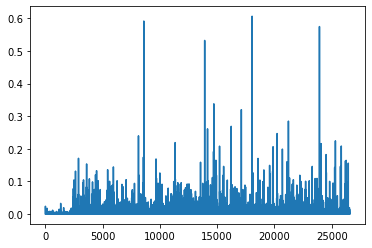

In [73]:
plt.plot(clf.components_[0])

In [74]:
clf.reconstruction_err_


43.712926057952764

### NMF in summary
    Benfits : Fast and easy to use !
    Downsides : took years of research and expertise to create

    Notes :
        1. For NMF, the matrix needs to be at least as tall as it is wide, or we get an error with fit transform
        2. Can use df_min inn CountVectorizer to only look at words that were in at least k of the split texts

### Truncated SVD
    We saved a lot of time, when we calculated NMF by only calculating the subset of columns we were intrested in. Is there a way to get this benefit in SVD? Yes ther is, It's called truncated SVD. We are just intrested in the vectors corresponding to the largest singular values


#### Shortcomings of classical algorithms for decomposition
    1. Matrices are stupendouslu big.
    2. Data are often missing or inaccurate.
    3. Data transfer now plays a major role in time of algorithms. Techniques that require fewer passes over the data may be substantially faster , even if they require more flops
    4. Important to take advanage of GPUs
   
#### Advantages of randomized Algorithms
    1. Ingerently stable
    2. performance gurantees do not depend on subtle spectral properties
    3. needed matrix-vector products can be done in parallel

### Timing Comparison


In [77]:
%%timeit
u,s,v = np.linalg.svd(vectors, full_matrices = False)

4min 44s ± 1min 45s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [79]:
from sklearn import decomposition
#import fbpca

In [80]:
%%timeit
u, s,v = decomposition.randomized_svd(vectors,10)

31.2 s ± 4.7 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
